In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2024/06/19

@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
Network Engineering Department
"""
###########################################################################
# Seminar on Quantum Technologies for Communications and Computing: Networking and Systems
# Self-study
# Session 1 - Introduction to Quantum Technologies for Communications and Computing

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files # This line can be commented when running in local computer
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:
  import qiskit
  import qiskit_aer
except:
  print("installing qiskit...")
  !pip install qiskit -U --quiet
  !pip install qiskit_aer -U --quiet
  print("installed qiskit.")
  import qiskit
  import qiskit_aer


# Self-study (5 hours):

# Readings for Managers and Doers
 - Class textbook.
 - https://arxiv.org/abs/quant-ph/0101098

# Exercices
- Managers guide doers in the work described below (results discussed in next class session).
- Managers: Search for a specific quantum topics of their interest to research and detail it and their findings in an Introduction section of the document outcome.
- Doers: Work the below script exercises

# Channel eavsdropping detection - Quantum Key Distribution

https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html

1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the Internet), it is essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this assignment, we will have to believe that Alice and Bob having a secret key that no one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fiber-optic cable, through which we can send individual photons (particles of light). Photons have a property called polarisation, and this polarisation can be one of two states. We can use this to represent a qubit.

2. Protocol Overview

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.

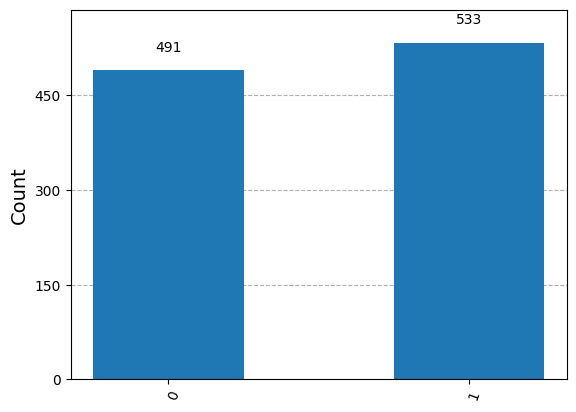

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint

# If Alice prepares a qubit in the state |+⟩  (0 in the  X -basis), and Bob measures it in the  X -basis, Bob is sure to measure 0:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Construct an ideal simulator
aersim = AerSimulator()

# Draw and simulate circuit
#display(qc.draw())
result=aersim.run(qc).result()
measured_registers=result.get_counts()
plot_histogram(measured_registers)

# But if Eve tries to measure this qubit in the Z -basis before it reaches Bob, she will change the qubit's state from  |+⟩  to either  |0⟩  or  |1⟩ , and Bob is no longer certain to measure 0:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
#display(qc.draw())
result=aersim.run(qc).result()
measured_registers=result.get_counts()
plot_histogram(measured_registers)
# We can see here that Bob now has a 50% chance of measuring 1, and if he does, he and Alice will know there is something wrong with their channel.


The quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. It is roughly as follows:

- Step 1

Alice chooses a string of random bits, e.g.:

1000101011010100

And a random choice of basis for each bit:

ZZXZXXXZXZXXXXXX

Alice keeps these two pieces of information private to herself.

- Step 2

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states
|0⟩ ,  |1⟩ ,  |+⟩  or  |−⟩ , chosen at random. In this case, the string of qubits would look like this:

|1⟩|0⟩|+⟩|0⟩|−⟩|+⟩|−⟩|0⟩|−⟩|1⟩|+⟩|−⟩|+⟩|−⟩|+⟩|+⟩

This is the message she sends to Bob.

- Step 3

Bob then measures each qubit at random, for example, he might use the bases:

XZZZXZXZXZXZZZXZ

And Bob keeps the measurement results private.

- Step 4

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

- Step 5

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

In [ ]:
# 3. Example: Without Interception
# Let’s first see how the protocol works when no one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. As always, let's start by importing everything we need:

# To generate pseudo-random keys, we will use the randint function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0:
np.random.seed(seed=0)
# We will call the length of Alice's initial message n. In this example, Alice will send a message 100 qubits long:
n = 100

## Step 1
# Alice generates random bits
alice_bits = randint(2, size=n)
print(f'Alice bits: {alice_bits.tolist()}')

# 3.2 Step 2: Alice chooses to encode each bit on qubit in the  X  or  Z -basis at random, and stores the choice for each qubit in alice_bases. In this case, a 0 means "prepare in the  Z -basis", and a 1 means "prepare in the  X -basis":
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(f'Alice bases: {alice_bases.tolist()}')
# The function encode_message below, creates a list of QuantumCircuits, each representing a single qubit in Alice's message:
def encode_message(bits, bases):
  message = []
  for i in range(n):
    qc = QuantumCircuit(1,1)
    if bases[i] == 0: # Prepare qubit in Z-basis
      if bits[i] == 0:
        pass
      else:
        qc.x(0)
    else: # Prepare qubit in X-basis
      if bits[i] == 0:
        qc.h(0)
      else:
        qc.x(0)
        qc.h(0)
    qc.barrier()
    message.append(qc)
  return message

# Create an array to tell us which qubits
# are encoded in which bases
message = encode_message(alice_bits, alice_bases)
print('We can see that the first bit in alices_bits is 0, and the basis she encodes this in is the  X-basis (represented by 1):')
print('Alice bit 1 = %i' % alice_bits[0])
print('Alice basis 1 = %i' % alice_bases[0])
#And if we view the first circuit in message (representing the first qubit in Alice's message), we can verify that Alice has prepared a qubit in the state |+⟩:
#message[0].draw()
print('As another example, we can see that the fourth bit in alice_bits is 1, and it is encoded in the  Z - basis, Alice prepares the corresponding qubit in the state |1⟩:')
print('Alice bit 4 = %i' % alice_bits[4])
print('Alice basis 4 = %i' % alice_bases[4])
#message[4].draw()

# 3.3 Step 3: Bob then measures each qubit in the  X  or  Z -basis at random and stores this information:
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(f'Bob bases: {bob_bases.tolist()}')
#Below, the function measure_message applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in bob_results.
def measure_message(message, bases):
  measurements = []
  for q in range(n):
    if bases[q] == 0: # measuring in Z-basis
      message[q].measure(0,0)
    if bases[q] == 1: # measuring in X-basis
      message[q].h(0)
      message[q].measure(0,0)
    t_message = transpile(message[q], optimization_level=3)
    result=aersim.run(t_message,shots=1, memory=True).result()
    measured_bit = int(result.get_memory()[0])
    measurements.append(measured_bit)
  return measurements
np.random.seed(seed=0)

## Step 3
# Decide which basis to measure in:
bob_results = measure_message(message, bob_bases)
#We can see that the circuit in message[0] (representing the 0th qubit) has had an  X -measurement added to it by Bob:
#Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result 0. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'.
#message[6].draw()
print(f'Bob results: {bob_results}')
#3.4 Step 4:
#After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis:
#And Bob reveals which basis he measured each qubit in:
#If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in bob_results will match the corresponding entry in alice_bits, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function remove_garbage that does this for us:
def remove_garbage(a_bases, b_bases, bits):
  good_bits = []
  for q in range(n):
    if a_bases[q] == b_bases[q]:
      # If both used the same basis, add
      # this to the list of 'good' bits
      good_bits.append(bits[q])
  return good_bits

#Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:
## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(f'Alice key: {alice_key}')

bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(f'Bob key: {bob_key}')

#3.5 Step 5:
#Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:
def sample_bits(bits, selection):
  sample = []
  for i in selection:
    # use np.mod to make sure the
    # bit we sample is always in
    # the list range
    i = np.mod(i, len(bits))
    # pop(i) removes the element of the
    # list at index 'i'
    sample.append(bits.pop(i))
  return sample
#Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

bob_sample = sample_bits(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))


#If the protocol has worked correctly without interference, their samples should match:
print(f'If the protocol has worked correctly without interference, their samples should match: {bob_sample == alice_sample}')
# If their samples match, it means (with high probability) alice_key == bob_key. They now share a secret key they can use to encrypt their messages!
print(f'Alice key: {alice_key}')
print(f'Bob key: {bob_key}')
print("key length = %i" % len(alice_key))

Alice bits: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Alice bases: [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
We can see that the first bit in alices_bits is 0, and the basis she encodes this in is the  X-basis (represented by 1):
Alice bit 1 = 0
Alice basis 1 = 1
As another example, we can see that the fourth bit in alice_bits is 1, and it is encoded in the  Z - basis, Alice prepares the corresponding qubit in the state |1⟩:
Alice bit 4 = 1
Alice basis 4 = 0
Bob bases: [1, 0, 1

In [ ]:
#4. Example: With Interception
#Let’s now see how Alice and Bob can tell if Eve has been trying to listen in on their quantum message. We repeat the same steps as without interference, but before Bob receives his qubits, Eve will try and extract some information from them. Let's set a different seed so we get a specific set of reproducible 'random' results:

n=100
#4.1 Step 1:
#Alice generates her set of random bits:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(f'Alice bits {alice_bits.tolist()}')

#4.2 Step 2:
#Alice encodes these in the  Z  and  X -bases at random, and sends these to Bob through Eve's quantum channel:
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(f'Alice basis {alice_bases.tolist()}')
#In this case, the first qubit in Alice's message is in the state  |+⟩ :
#message[0].draw()
# Interception!

print('Oh no! Eve intercepts the message as it passes through her channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.')
## Interception!!
eve_bases = randint(2, size=n)
print(f'Eve bases: {eve_bases.tolist()}')
intercepted_message = measure_message(message, eve_bases)
print(f'Intercepted message: {intercepted_message}')
#We can see the case of qubit 0 below; Eve's random choice of basis is not the same as Alice's, and this will change the qubit state from |+⟩ , to a random state in the  Z -basis, with 50% probability of  |0⟩  or  |1⟩ :
#message[0].draw()
#4.3 Step 3:
#Eve then passes on the qubits to Bob, who measures them at random. In this case, Bob chose (by chance) to measure in the same basis Alice prepared the qubit in. Without interception, Bob would be guaranteed to measure 0, but because Eve tried to read the message he now has a 50% chance of measuring 1 instead.
## Step 3
bob_bases = randint(2, size=n)
print(f'Bob bases: {bob_bases.tolist()}')
bob_results = measure_message(message, bob_bases)
print(f'Bob results: {bob_results}')
#message[0].draw()
# 4.4 Step 4:
# Bob and Alice reveal their basis choices, and discard the useless bits:

## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# 4.5 Step 5:
# Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

bob_sample = sample_bits(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))

if (bob_sample != alice_sample):
  print('Oh no! Bob key and Alice key do not match. We know this is because Eve tried to read the message between steps 2 and 3, and changed the qubits states. For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve interception attempt has failed.')
else:
  print("Eve went undetected!")

Alice bits [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Alice basis [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Oh no! Eve intercepts the message as it passes through her channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.
Eve bases: [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0

5. Risk Analysis
For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match, and Alice sends her vulnerable message through Eve's channel. Let's calculate that chance and see how risky quantum key distribution is.

For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, she will successfully intercept this bit without introducing any error. There is a 50% chance of this happening.
If Eve chooses the wrong basis, i.e. a different basis to Alice and Bob, there is still a 50% chance Bob will measure the value Alice was trying to send. In this case, the interception also goes undetected.
But if Eve chooses the wrong basis, i.e. a different basis to Alice and Bob, there is a 50% chance Bob will not measure the value Alice was trying to send, and this will introduce an error into their keys.
risk probability tree

If Alice and Bob compare 1 bit from their keys, the probability the bits will match is 0.75, and if so they will not notice Eve's interception. If they measure 2 bits, there is a 0.75^2=0.5625 chance of the interception not being noticed. We can see that the probability of Eve going undetected can be calculated from the number of bits (n) Alice and Bob chose to compare:

P(undetected)=0.75^n
If we decide to compare 15 bits as we did above, there is a 1.3% chance Eve will be undetected. If this is too risky for us, we could compare 50 bits instead, and have a 0.00006% chance of being spied upon unknowingly.

You can retry the protocol again by running the cell below. Try changing sample_size to something low and see how easy it is for Eve to intercept Alice and Bob's keys.

# Exercise - Sample size matters to detect Eve

Change sample_size value to something lower (than 50) and see if Eve can intercept the message without Alice and Bob finding out (repeat several times).

 - When is it more probable to detect Eve, for large values of sample_size or for lower values? Explain why?

In [ ]:
sample_size = int(50) # Change this value to something lower and see if Eve can intercept the message without Alice and Bob finding out (repeat several times)
n = int(200)
if (sample_size>=(2*n)):
  sample_size=int(n/2-1)
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5

bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if (bob_sample != alice_sample):
  print("Eve's presence was detected.")
else:
  print("Eve's presence went undetected!")

Eve's presence was detected.


# Exercise - Develop a quantum model to simulate a BB84 protocol:
 - Follow the instructions from: https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Cryptography/QuantumKeyDistribution.ipynb

# Wrap-up of Probability errors and Fidelity

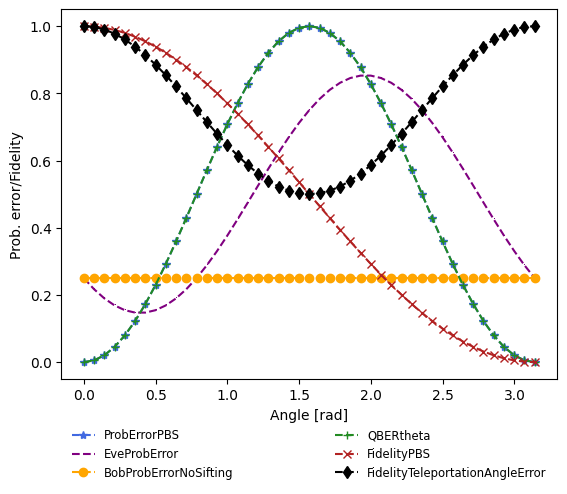

In [ ]:
##############################################################################
# Relation of Probability errors, QBER, Fidelities with the the rotation of the measurement basis \theta
NcalcAngle=45
MaxAngle=np.pi
AnglesScan=np.linspace(0,MaxAngle,NcalcAngle)

ProbErrorPBS=1.0-np.cos(AnglesScan)**2
EveProbError=0.25*((1.0-np.cos(2.0*AnglesScan))+(1.0-np.sin(2.0*AnglesScan))) # Error probability when Eve is randomly changing basis (it is minimized to 14.64% when theta=np.pi/8 - Breidbart basis)
BobProbErrorNoSifting=0.25*((1.0-np.cos(2.0*AnglesScan)**2)+(1.0-np.sin(2.0*AnglesScan)**2)) # Error probability when Bob is randomly changes basis (before key sifting)
QBERtheta=1.0-np.cos(AnglesScan)**2 # Error probability equivalent to Bob when doing sifting
FidelityPBS=1.0-np.sin(AnglesScan/2.0)**2# Angle is half, because at np.pi/2.0 its like at half place between the two states
FidelityTeleportationAngleError=1.0-ProbErrorPBS/2.0
# Fidelity towards a Bell state if usually as F=0.5*(1+cos(\theta)); depending on the Bell state of interest \theta has to be adjusted or even the cos can be replaced by a sin
# Fidelity cascaded devices F=Fi**N
# Fidelity in terms of coincidences F=RatioRc/(1.0+RatioRc), where RatioRc is the ratio of coincidences between RcParallel/RcOrthogonal (Rc coincidence rate)

plt.figure()
line1,=plt.plot(AnglesScan,ProbErrorPBS,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(AnglesScan,EveProbError,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(AnglesScan,BobProbErrorNoSifting,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(AnglesScan,QBERtheta,'forestgreen',linestyle='dashed',marker='+')
line5,=plt.plot(AnglesScan,FidelityPBS,'firebrick',linestyle='dashed',marker='x')
line6,=plt.plot(AnglesScan,FidelityTeleportationAngleError,'black',linestyle='dashed',marker='d')
plt.legend((line1, line2, line3, line4, line5, line6), ('ProbErrorPBS','EveProbError','BobProbErrorNoSifting','QBERtheta','FidelityPBS','FidelityTeleportationAngleError'),bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.xlabel('Angle [rad]',color='k')
plt.ylabel('Prob. error/Fidelity',color='k')
plt.show()

####################################################
# Relevant transmittivity/loss related equations:
# Rr=eta Rs # where eta is the transmissivity as eta \leq 1 and proportional to np.exp(-att Distance), where att is the attenuation att\geq 0.
# dBatt=dBLoss/Km*L(Km)
# dBatt=-10 log10(eta)
# ProbabilityPhotonLoss=1-eta=1-np.exp(-Distance/L0), where dBLoss/Km * L0=-10 log10(1/e)

####################################################
# Relevant trigonometric relations
# cos(theta)**2+sin(theta)**2=1
# sin(theta)**2=0.5*(1-cos(2theta))
# cos(theta)**2=0.5*(1+cos(2theta))